In [1]:
## Imports needed
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2025-06-27 12:36:02.925503: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 12:36:02.966717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 12:36:03.389141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 12:36:03.401027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-27 12:36:05.592653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
## Data Creation Script
# 1) Data generation & prep ================================================
def generate_sine_wave(freq=1.5, amp=1.0, dur=20, pts=2000, noise=0.02):  # Longer duration, more points, less noise
    t = np.linspace(0, dur, pts)
    wave = amp * np.sin(2 * np.pi * freq * t)
    return wave + np.random.normal(0, noise, pts)

data = generate_sine_wave()

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

def create_sequences(d, enc_steps=100, dec_steps=150):  # Longer sequences
    Xenc, Xdec, y = [], [], []
    for i in range(len(d) - enc_steps - dec_steps + 1):
        Xenc.append(d[i : i + enc_steps])
        Xdec.append(d[i + enc_steps - 1 : i + enc_steps + dec_steps - 1])
        y.append(d[i + enc_steps : i + enc_steps + dec_steps])
    return np.array(Xenc)[..., None], np.array(Xdec)[..., None], np.array(y)

enc_steps, dec_steps = 100, 150
X_enc, X_dec, Y = create_sequences(scaled, enc_steps, dec_steps)
split = int(0.8 * len(X_enc))
X_e_tr, X_e_te = X_enc[:split], X_enc[split:]
X_d_tr, X_d_te = X_dec[:split], X_dec[split:]
Y_tr,    Y_te    = Y[:split],    Y[split:]

batch_size = 32
steps_per_epoch = len(X_e_tr) // batch_size

Epoch 1/5
44/44 [==============================] - 37s 493ms/step - mae: 13.0344 - val_mae: 0.0000e+00
Epoch 2/5
44/44 [==============================] - 23s 523ms/step - mae: 35.5119 - val_mae: 0.0000e+00
Epoch 3/5
44/44 [==============================] - 24s 540ms/step - mae: 29.1547 - val_mae: 0.0000e+00
Epoch 4/5
44/44 [==============================] - 25s 580ms/step - mae: 30.0228 - val_mae: 0.0000e+00
Epoch 5/5
44/44 [==============================] - 29s 668ms/step - mae: 28.7050 - val_mae: 0.0000e+00


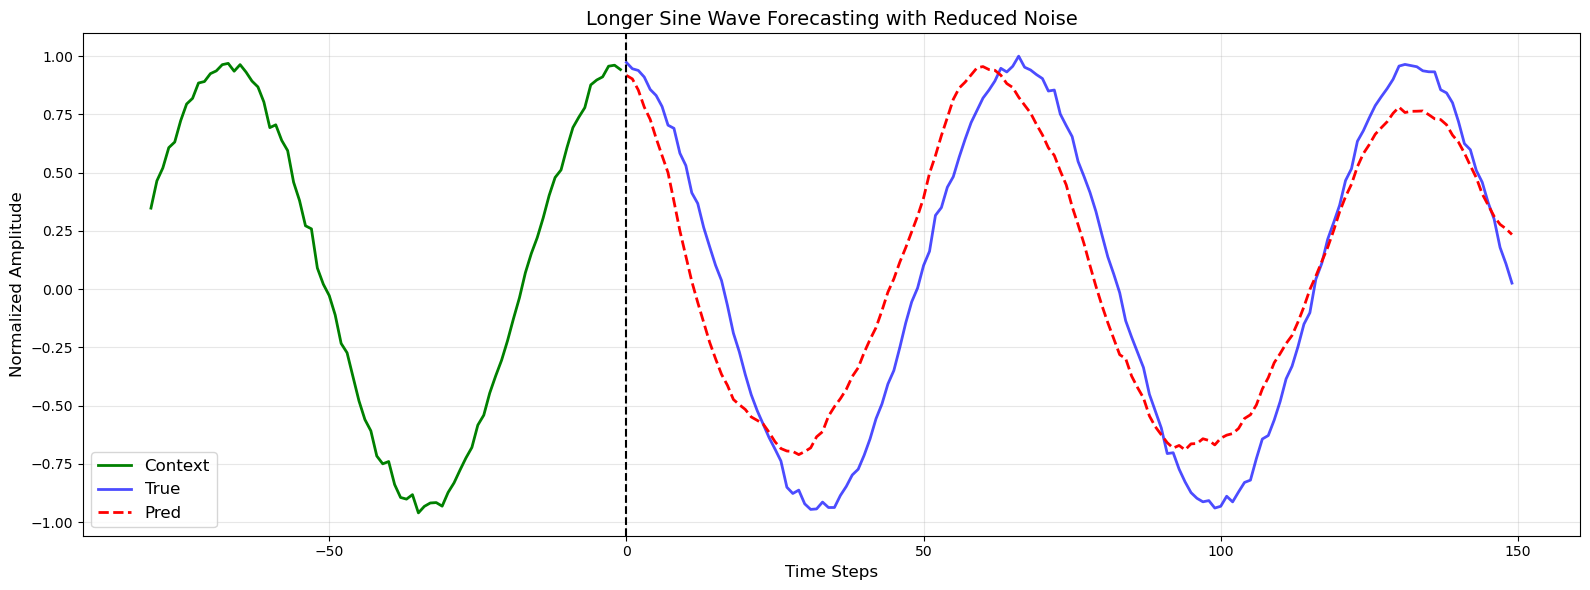

In [4]:
## less noise loner sine waves

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Layer
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# # 1) Data generation & prep ================================================
# def generate_sine_wave(freq=1.5, amp=1.0, dur=20, pts=2000, noise=0.02):  # Longer duration, more points, less noise
#     t = np.linspace(0, dur, pts)
#     wave = amp * np.sin(2 * np.pi * freq * t)
#     return wave + np.random.normal(0, noise, pts)

# data = generate_sine_wave()

# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# def create_sequences(d, enc_steps=100, dec_steps=150):  # Longer sequences
#     Xenc, Xdec, y = [], [], []
#     for i in range(len(d) - enc_steps - dec_steps + 1):
#         Xenc.append(d[i : i + enc_steps])
#         Xdec.append(d[i + enc_steps - 1 : i + enc_steps + dec_steps - 1])
#         y.append(d[i + enc_steps : i + enc_steps + dec_steps])
#     return np.array(Xenc)[..., None], np.array(Xdec)[..., None], np.array(y)

# enc_steps, dec_steps = 100, 150
# X_enc, X_dec, Y = create_sequences(scaled, enc_steps, dec_steps)
# split = int(0.8 * len(X_enc))
# X_e_tr, X_e_te = X_enc[:split], X_enc[split:]
# X_d_tr, X_d_te = X_dec[:split], X_dec[split:]
# Y_tr,    Y_te    = Y[:split],    Y[split:]

# batch_size = 32
# steps_per_epoch = len(X_e_tr) // batch_size

# 2) Positional Encoding Layer =============================================
class PositionalEncoding(Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        angles = 1 / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
        pos   = np.arange(max_len)[:, None] * angles[None, :]
        pe    = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(pos[:, 0::2])
        pe[:, 1::2] = np.cos(pos[:, 1::2])
        self.pe = tf.constant(pe[None, ...], dtype=tf.float32)
    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pe[:, :seq_len, :]

# 3) Custom Transformer Model with causal mask & scheduled sampling ========
class ForecastTransformer(Model):
    def __init__(self, enc_steps, dec_steps, d_model=128, heads=4, ff_dim=256, layers=3):  # Larger model
        super().__init__()
        self.enc_steps, self.dec_steps = enc_steps, dec_steps
        mask = tf.linalg.band_part(tf.ones((dec_steps, dec_steps)), -1, 0)
        self.causal_mask = mask[None, None, :, :]
        # Encoder
        self.enc_dense = Dense(d_model)
        self.enc_pe    = PositionalEncoding(enc_steps, d_model)
        self.enc_blocks = []
        for _ in range(layers):
            self.enc_blocks.append({
                "attn":  MultiHeadAttention(heads, d_model//heads),
                "ffn1":  Dense(ff_dim, activation="relu"),
                "ffn2":  Dense(d_model),
                "norm1": LayerNormalization(axis=-1, epsilon=1e-6),
                "norm2": LayerNormalization(axis=-1, epsilon=1e-6),
                "drop":  Dropout(0.1)
            })
        # Decoder
        self.dec_dense  = Dense(d_model)
        self.dec_pe     = PositionalEncoding(dec_steps, d_model)
        self.dec_blocks = []
        for _ in range(layers):
            self.dec_blocks.append({
                "self_attn":  MultiHeadAttention(heads, d_model//heads),
                "cross_attn": MultiHeadAttention(heads, d_model//heads),
                "ffn1":       Dense(ff_dim, activation="relu"),
                "ffn2":       Dense(d_model),
                "norm1":      LayerNormalization(axis=-1, epsilon=1e-6),
                "norm2":      LayerNormalization(axis=-1, epsilon=1e-6),
                "norm3":      LayerNormalization(axis=-1, epsilon=1e-6),
                "drop":       Dropout(0.1)
            })
        # Projections
        self.out_dense  = Dense(1)    # used on full decoder output
        self.step_dense = Dense(1)    # used for scheduled sampling
        # Loss & metric
        self.loss_fn = MeanAbsoluteError()
        self.loss_tracker = tf.keras.metrics.Mean(name="mae")
    @property
    def metrics(self):
        return [self.loss_tracker]
    def call(self, inputs, training=False):
        x_enc, x_dec = inputs
        # Encoder
        x = self.enc_dense(x_enc); x = self.enc_pe(x)
        for blk in self.enc_blocks:
            a = blk["drop"](blk["attn"](x, x), training=training)
            x = blk["norm1"](x + a)
            f = blk["ffn2"](blk["ffn1"](x)); x = blk["norm2"](x + f)
        enc_out = x
        # Decoder
        y = self.dec_dense(x_dec); y = self.dec_pe(y)
        for blk in self.dec_blocks:
            sa = blk["self_attn"](y, y, attention_mask=self.causal_mask)
            sa = blk["drop"](sa, training=training); y = blk["norm1"](y + sa)
            ca = blk["cross_attn"](y, enc_out)
            ca = blk["drop"](ca, training=training); y = blk["norm2"](y + ca)
            f = blk["ffn2"](blk["ffn1"](y)); y = blk["norm3"](y + f)
        out = self.out_dense(y)
        return tf.squeeze(out, -1)
    def train_step(self, data):
        (x_enc, x_dec), y_true = data
        epoch = tf.cast(self.optimizer.iterations // steps_per_epoch, tf.float32)
        eps = tf.minimum(0.5, epoch * (0.5 / 10.0))
        # build decoder inputs with sampling
        dec_in = tf.TensorArray(tf.float32, size=self.dec_steps)
        last = x_enc[:, -1, 0]
        t0 = tf.constant(0)
        def cond(t, *_): return tf.less(t, self.dec_steps)
        def body(t, dec_in, last):
            use_model = tf.random.uniform(()) < eps
            inp = tf.where(use_model, last, x_dec[:, t, 0])
            dec_in = dec_in.write(t, inp)
            last = self.step_dense(
                tf.expand_dims(tf.expand_dims(inp, -1), 1), training=True
            )[:, 0, 0]
            return t + 1, dec_in, last
        _, dec_in_final, _ = tf.while_loop(cond, body, [t0, dec_in, last])
        dec_seq = tf.transpose(dec_in_final.stack(), [1, 0]); dec_seq = tf.expand_dims(dec_seq, -1)
        with tf.GradientTape() as tape:
            preds = self([x_enc, dec_seq], training=True)
            loss = self.loss_fn(y_true, preds)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(y_true, preds)
        return {"mae": self.loss_tracker.result()}

# 4) Instantiate, compile & train ==========================================
model = ForecastTransformer(enc_steps, dec_steps)
model.compile(optimizer=Adam(1e-4))
model.fit(
    (X_e_tr, X_d_tr), Y_tr,
    validation_data=((X_e_te, X_d_te), Y_te),
    epochs=5, batch_size=batch_size  # More epochs
)

# 5) Inference & visualization ============================================
def predict_autoregressive(m, enc_input, dec_steps):
    dec_in = np.zeros((1, dec_steps, 1), np.float32)
    dec_in[0, 0, 0] = enc_input[0, -1, 0]
    preds = []
    for i in range(dec_steps):
        out = m.predict([enc_input, dec_in], verbose=0)[0, i]
        preds.append(out)
        if i + 1 < dec_steps: dec_in[0, i+1, 0] = out
    return np.array(preds)

idx = 50
enc_context = X_e_te[idx:idx+1]
true_fut    = Y_te[idx]
pred_fut    = predict_autoregressive(model, enc_context, dec_steps)

plt.figure(figsize=(16,6))
context_length = 80  # Show more context
plt.plot(range(-context_length,0), enc_context[0,-context_length:,0], 'g-', linewidth=2)
plt.plot(range(dec_steps), true_fut, 'b-', alpha=0.7, linewidth=2)
plt.plot(range(dec_steps), pred_fut, 'r--', linewidth=2)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Normalized Amplitude', fontsize=12)
plt.legend(['Context','True','Pred'], fontsize=12)
plt.title('Longer Sine Wave Forecasting with Reduced Noise', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('transformer_forecast_improved.png')
plt.show()